# Color quantization and white line detection after applying mean shift filtering

This notebook is highly based on the code Matthew and Junjie have wrotten with minor modifications done by me. Here, I used the OpenCV libaray and put a fixed white BGR for predicting label. I applied mean shift filter to blurr the texture of the image before applying the color quantization. Hopefully, by doing this, we won't pick up the unwanted white line on the curbs of the road. Only Road3 image will be looked at in this notebook. 

In [1]:
# import libraries
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import cv2
from pathlib import Path

In [2]:
# define reshaped size
WIDTH = 512
HEIGHT = 512

In [3]:
# define a list with all file names
pl = Path("Parking Lot")
rd = Path("Road")

filenames = [str(file) for file in pl.iterdir()]
filenames = filenames + [str(file) for file in rd.iterdir()]

num_files = len(filenames)

In [4]:
# apply mean shift filtering.
# the spatial window radius = 20, the color window radius = 60. These two parameters can be adjusted
ims = [cv2.pyrMeanShiftFiltering(cv2.resize(cv2.imread(file),(WIDTH,HEIGHT)),20,60) for file in filenames]

In [5]:
# reshape the list
pixel_list = [im.reshape((-1, 3)) for im in ims]
pixels = np.concatenate(pixel_list, axis=0)

In [6]:
# apply clustering on all images
n_clusters=10

model = KMeans(n_clusters=n_clusters)
model.fit(pixels)

KMeans(n_clusters=10)

In [7]:
# define the white color and predict the label 
white = np.array([255, 255, 255 ])
white_label = model.predict(white.reshape((1, -1)))

In [8]:
# save all the clustered images and the resulting images after filtering 

for index in range(num_files):
    filename = filenames[index].split('/')[-1].split('.')[0]
    
    #resized_img = pixels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)].reshape((HEIGHT, WIDTH, 3))

    colors = model.cluster_centers_
    img_labels = model.labels_
    transformed_img = colors[(img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)])].reshape((HEIGHT, WIDTH, 3))
    output_name = "Output/Color_Quantization_white2/Transformed_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,transformed_img)

    mask = (img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)] == white_label).reshape((HEIGHT, WIDTH, 1))
    masked_image = ims[index]*mask
    output_name = "Output/Color_Quantization_white2/Masked_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,masked_image)

## Now let's take a look at these masked images and do analysis from there 

Our resized image has the shape: (512, 512, 3)


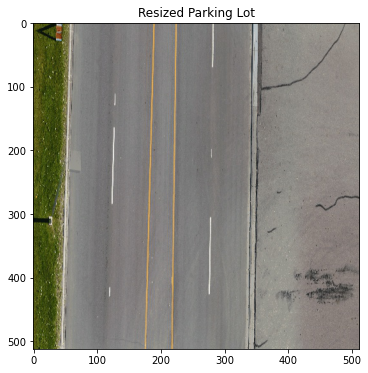

In [9]:
# load road3 image 
filen = "Road3"
resizedfilename = "Output/Color_Quantization_2/Resized_"+filen+".jpg"
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Resized Parking Lot');
print("Our resized image has the shape: {}".format(img_resized.shape))
plt.imshow(img_resized)
plt.show()

Our masked image has the shape: (512, 512, 3)


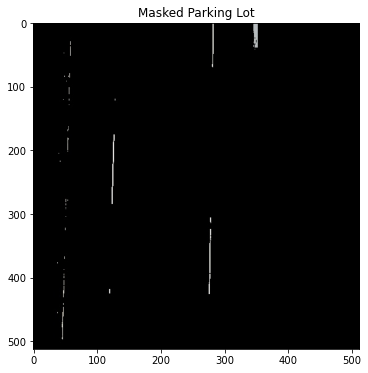

In [10]:
# load masked image 
maskedfilename = "Output/Color_Quantization_white2/Masked_"+filen+".jpg"
masked_img = cv2.imread(maskedfilename, 1)
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Masked Parking Lot');
print("Our masked image has the shape: {}".format(masked_img.shape))
plt.imshow(masked_img)
plt.show()

In [11]:
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

In [12]:
# parameters kernel size and sigma in Gaussian blur
gblur = cv2.GaussianBlur(masked_img, (7,7),0)

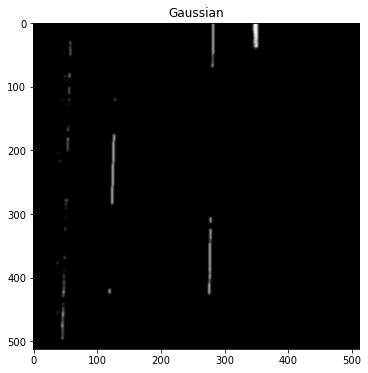

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(gblur, cmap = 'gray')
plt.title('Gaussian');
plt.show()

In [14]:
# two parameters need to play with in canny edge detection
minval = 100
maxval = 200
canny_bF = cv2.Canny(gblur, minval, maxval)

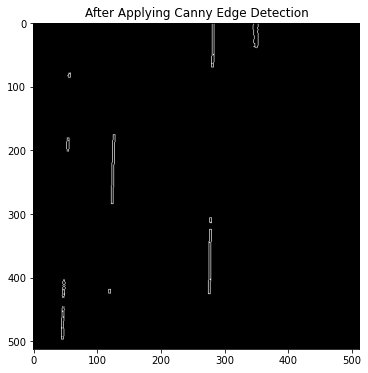

True

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(canny_bF, cmap = 'gray')
plt.title('After Applying Canny Edge Detection');
plt.show()
finaloutname = "Output/Color_Quantization_white2/Edge_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
cv2.imwrite(finaloutname,canny_bF )

In [16]:
# three parameters need to play with in Hough line detection
lines = cv2.HoughLinesP(canny_bF, 1, np.pi/180, threshold = 20, minLineLength = 18, maxLineGap = 10)

In [17]:
# draw the detected white lines
for line in lines:
    x1, y1, x2, y2 = line[0]   
    im = cv2.line(img_resized, (x1,y1), (x2, y2), ( 255, 0, 0), 2)

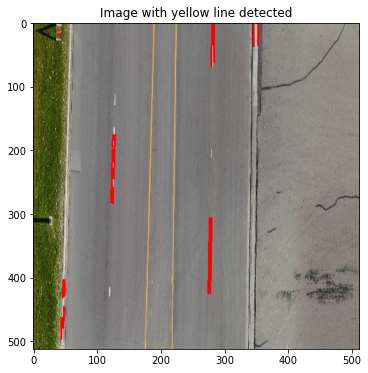

True

In [18]:
#img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(im)
plt.title('Image with yellow line detected');
plt.show()

# save the image with line detected and display it
finaloutname = "Output/Color_Quantization_white2/Detected_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
cv2.imwrite(finaloutname, im)

What I did (same as Day8.1 notebook): 
* To detect the long white lines in Road3, I used kernal = 7,  minval = 100, maxval = 200, threshold = 20, minlinelength = 18, maxlinegap = 10

Result looks better compare to the result without the mean shift filter. However, I better solution is needed since there are still curbs and the line on curb gotten detected.